In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fftpack import fft
import os

In [34]:

def preprocessing(signal,accuracy,sigma):
    df = signal
    #df = pd.read_csv(filename, header = 2)
    df = df.loc[:,["y","likelihood"]]
    df = df[df["likelihood"]>accuracy]
    df = df.loc[:,["y"]]
    df1 = (df - df.mean())/df.std()
    df1 = df1.rename(columns = {'y':'zscore'})
    df = df.join(df1)
    df = df[df["zscore"]>-sigma]
    df = df[df["zscore"]<sigma]
    if sum(np.isnan(df['y'])) > 0:
        print('nan found in pp!')
        df = df[~np.isnan(df['y'])]
    return(df)

def getWaveStats(y):
    peaks = signal.find_peaks(y, distance = 3)
    peaks = peaks[0].astype(int)
    widths,_,_,_ = signal.peak_widths(y, peaks, rel_height=0.5)
    wave_stats = pd.Series({'mean': widths.mean(), 'std': widths.std(), 'median': np.median(widths)})
    return(wave_stats)
    
def findBottoms(wave, peaks):
    if len(peaks) == 0:
        bottoms = np.min(wave)
    else:
        bottoms = np.zeros(len(peaks)+1)
        peaks = np.concatenate([[0], peaks, [len(wave)-1]])
        for seg_idx in range(len(bottoms)):
            bottoms[seg_idx] = np.argmin(wave[peaks[seg_idx]:peaks[seg_idx+1]]) + peaks[seg_idx]
    bottoms = bottoms.astype(int)
    return bottoms
            
def getHeartBeats(wave, min_distance):
    peaks = signal.find_peaks(wave, distance=min_distance)
    peaks = peaks[0].astype(int)
    bottoms = findBottoms(wave, peaks)
    
    df = pd.DataFrame({
        'left_width': peaks - bottoms[:-1],
        'right_width': bottoms[1:] - peaks,
        'left_height': wave[peaks] - wave[bottoms[:-1]],
        'right_height': wave[peaks] - wave[bottoms[1:]],
        'peak_y': wave[peaks]})
    return df
    

    
def getPsd(y, sample_freq):
    y_zscore = (y - np.mean(y)) / np.std(y)
    y_fft = fft(y_zscore)
    y_psd = (np.abs(y_fft) / len(y_fft)) ** 2
    sample_freq = 30
    y_psd_freq = np.arange(len(y_psd)) / (len(y_psd) / sample_freq)
    y_psd_freq = y_psd_freq[y_psd_freq < (sample_freq / 2)]
    y_psd = y_psd[:len(y_psd_freq)]
    return (y_psd, y_psd_freq)

def getPsdVec(psd, freq, freq_range, n_bins):
    psd_vec = np.zeros(n_bins)
    boundaries = np.linspace(freq_range[0], freq_range[1], n_bins+1)
    psd_vec = [np.mean(psd[(freq > boundaries[i]) & (freq < boundaries[i+1])]) for i in range(n_bins)]
    freq = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(n_bins)]
    return (psd_vec, freq)
    
def splitSignal(y, window_size, step_size):
    assert(len(y) > window_size)
    assert(window_size > step_size)
    y_list = []
    for startindex in range(0, y - int(window_size), int(window_size)):
        y_list.append(y[startindex:startindex + int(window_size)])
    return y_list

def generateColleciveDf(data_folder, acc, sigma, sample_freq, freq_range, n_bins, window_time, step_time):
    global yIn
    wave_dfs_list = []
    psd_vec_list = []
    category_list = []
    for root, dirs, files in os.walk(data_folder):
        if len(files) > 0:
            #print(root)
            category = (root[len(data_folder)+1:])
            for csv in files:
                if len(csv) > 25:
                    # new data, good format
                    csv_path = os.path.join(root, csv)
                    data = pd.read_csv(csv_path, header=2)
                    try:
                        data_pp = preprocessing(data, accuracy=acc, sigma=sigma)
                    except:
                        print('* preprocessing error: ' + os.path.join(category, csv))
                        continue
                    y = data_pp.y.values

                    if (len(y) / len(data) < 0.8):
                        print('too low quality: ' + os.path.join(category, csv) + '(' + str(len(y)) + ' in ' + str(len(data)) + ')')
                        # plt.figure(figsize=[20,3])
                        # plt.plot(data.y, linewidth=0.5)
                        # plt.axhline(data.y.mean(), c='k')
                        # bad_idx = np.setdiff1d(data.index, data_pp.index)
                        # plt.scatter(x=bad_idx, y=data.loc[bad_idx].y, s=3, c='r')
                        # plt.show()
                        # plt.figure(figsize=[20,3])
                        # plt.plot(data.likelihood, linewidth=0.5)
                        # plt.show()
                        continue
                else:
                    # old data, no format
                    csv_path = os.path.join(root, csv)
                    y = pd.read_csv(csv_path, header=None)
                    y = y.values
                    if len(y.shape) > 0:
                        y = y[:,0]
                    y = y[~np.isnan(y)]
                # try: 
                #     stats = getWaveStats(y)
                # except:
                #     print('* getStats error: ' + os.path.join(category, csv))
                #     continue
                
                full_length_y = y
                window_size = np.floor(sample_freq * window_time)
                step_size = np.floor(sample_freq * step_time)
                for y in splitSignal(full_length_y, window_size, step_size):
                    y_psd, y_psd_freq = getPsd(y, sample_freq)
                    global  psd_vec_freq
                    psd_vec, psd_vec_freq = getPsdVec(y_psd,y_psd_freq, freq_range, n_bins)
                    if sum(np.isnan(psd_vec)) > 0:


                        print(os.path.join(category, csv))
                        if sum(np.isnan(y))>0:
                            print('nan found in y!')
                            print(y)
                        

    #                 heartbeats = getHeartBeats(y, min_distance=3)
    #                 wave_stats_list.append(stats)

                    psd_vec_list.append(psd_vec)
                    category_list.append(category)

#             wave_stats_df = pd.DataFrame(wave_stats_list, columns = ['mean', 'std', 'median'])
            
#             wave_stats_df['category'] = category
#             wave_dfs_list.append(wave_stats_df)
#     wave_stats_df = pd.concat(wave_dfs_list, axis=0)
    psd_mat = np.array(psd_vec_list)
    category_list = [cat.split('\\')[0] for cat in category_list]
    categories = np.array(category_list)
    
    # return wave_stats_df
    return (psd_mat, psd_vec_freq, categories)

In [35]:
plt.figure(figsize=[40, 6])
#plt.imshow(np.log(psd_mat).T, aspect='auto', origin='lower')

<Figure size 2880x432 with 0 Axes>

<Figure size 2880x432 with 0 Axes>

In [36]:
data_folder = r'Z:\Data\InternalStateClustering\CSV_Tidyup_0125'
out_folder = r'Z:\Data\InternalStateClustering\out'

In [37]:
psd_mat, freqs, categories = generateColleciveDf(data_folder, acc=0.5, sigma=3, sample_freq=30, freq_range=[0, 10], n_bins=40, window_time=30, step_time=5)
np.savetxt(os.path.join(out_folder, 'psd_mat.csv'), psd_mat, fmt='%f', delimiter=',')
np.savetxt(os.path.join(out_folder, 'psd_freqs.csv'), freqs, fmt='%f', delimiter=',')
np.savetxt(os.path.join(out_folder, 'categories.csv'), categories, fmt='%s', delimiter=',')

NameError: name 'psd_vec_freq' is not defined

# 下面别动

In [11]:
wave_stats = generateColleciveDf(data_folder, acc=0.5, sigma=3)
wave_stats['category'] = [cat.split('\\')[0] for cat in wave_stats['category']]

wave_stats.to_csv(os.path.join(out_folder, 'wave_stats.csv'))

TypeError: generateColleciveDf() missing 5 required positional arguments: 'sample_freq', 'freq_range', 'n_bins', 'window_time', and 'step_time'

In [ ]:
plt.figure(figsize=[12,3], facecolor='white')
plt.subplot(1,3,1)
sns.barplot(data=wave_stats[[(cat in ['Normal', '14Day', '28Day']) for cat in wave_stats.category]], x='category', y='mean')
plt.subplot(1,3,2)
sns.barplot(data=wave_stats[[(cat in ['Normal', '14Day', '28Day']) for cat in wave_stats.category]], x='category', y='std')
plt.subplot(1,3,3)
sns.barplot(data=wave_stats[[(cat in ['Normal', '14Day', '28Day']) for cat in wave_stats.category]], x='category', y='median')
plt.show()

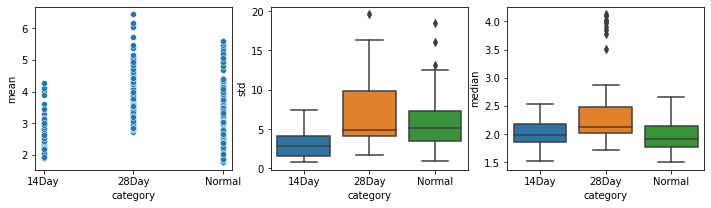

In [29]:
plt.figure(figsize=[12,3], facecolor='white')
plt.subplot(1,3,1)
sns.scatterplot(data=wave_stats[[(cat in ['Normal', '14Day', '28Day']) for cat in wave_stats.category]], x='category', y='mean')
plt.subplot(1,3,2)
sns.boxplot(data=wave_stats[[(cat in ['Normal', '14Day', '28Day']) for cat in wave_stats.category]], x='category', y='std')
plt.subplot(1,3,3)
sns.boxplot(data=wave_stats[[(cat in ['Normal', '14Day', '28Day']) for cat in wave_stats.category]], x='category', y='median')
plt.show()

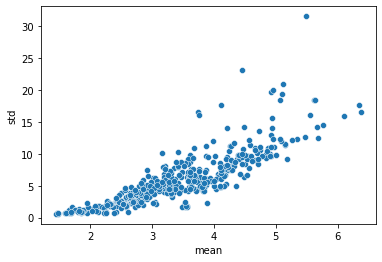

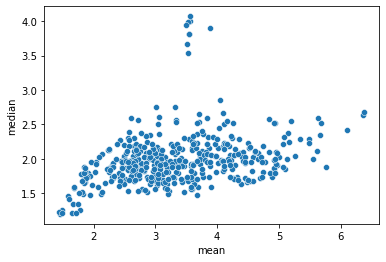

In [88]:
sns.scatterplot(data=wave_stats, x='mean', y='std')
plt.show()
sns.scatterplot(data=wave_stats, x='mean', y='median')
plt.show()

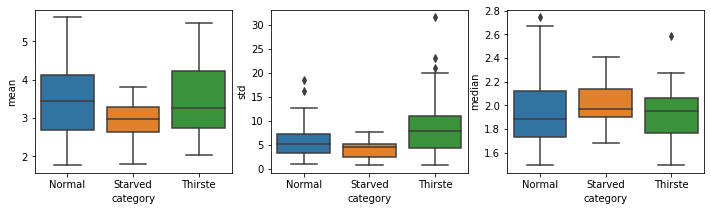

In [109]:
plt.figure(figsize=[12,3], facecolor='white')
plt.subplot(1,3,1)
sns.boxplot(data=wave_stats[[(cat in ['Normal', 'Thirste', 'Starved']) for cat in wave_stats.category]], x='category', y='mean')
plt.subplot(1,3,2)
sns.boxplot(data=wave_stats[[(cat in ['Normal', 'Thirste', 'Starved']) for cat in wave_stats.category]], x='category', y='std')
plt.subplot(1,3,3)
sns.boxplot(data=wave_stats[[(cat in ['Normal', 'Thirste', 'Starved']) for cat in wave_stats.category]], x='category', y='median')
plt.show()

In [37]:
np.array([True, False]) & np.array([False, True])

array([False, False])